In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install -q transformers accelerate datasets


In [ ]:
!git clone https://github.com/dml-qom/FarsTail.git
!ls FarsTail/data

import pandas as pd

test = pd.read_csv('FarsTail/data/Test-word.csv', sep='\t')
train = pd.read_csv('FarsTail/data/Train-word.csv', sep='\t')
val = pd.read_csv('FarsTail/data/Val-word.csv', sep='\t')


Cloning into 'FarsTail'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 137 (delta 26), reused 18 (delta 18), pack-reused 104 (from 1)
Receiving objects: 100% (137/137), 43.86 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Indexed-FarsTail.npz  Test-word.csv  Train-word.csv  Val-word.csv


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some weights of Gemma3TextForSequenceClassification were not initialized from the model checkpoint at google/gemma-3-270m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

/tmp/ipython-input-418764259.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.135200,1.151407,0.376057,0.375277
2,1.117300,1.122008,0.389720,0.377534
3,1.112200,1.108618,0.402733,0.402447
4,1.092700,1.097706,0.411841,0.398178
5,1.085100,1.090303,0.415745,0.412699


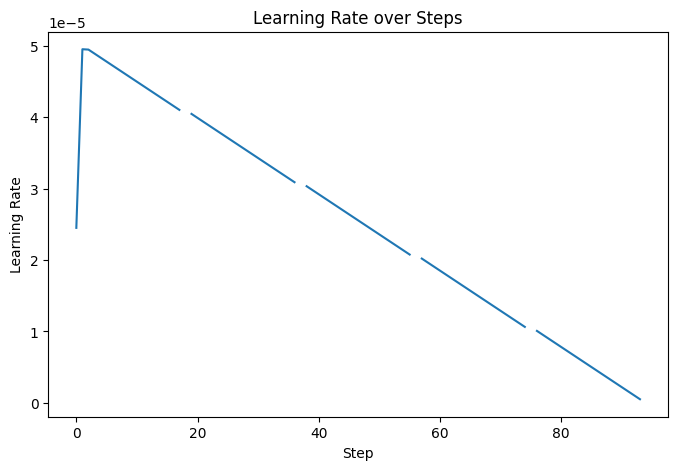

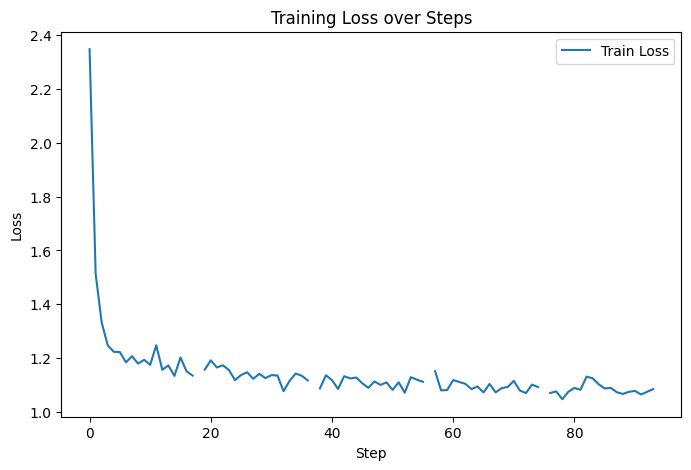

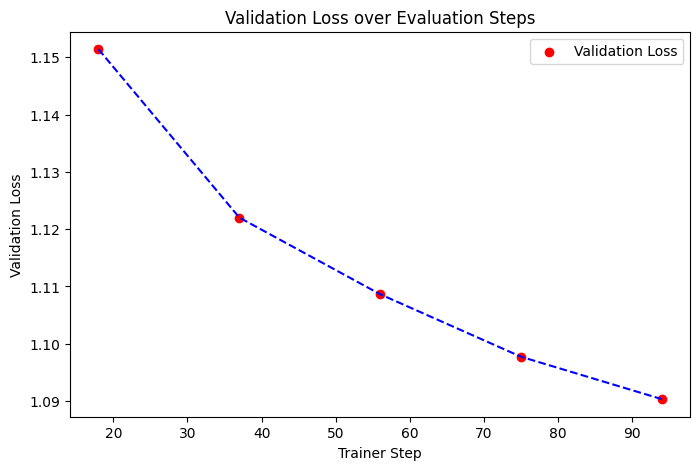

Validation Accuracy: 0.4157
Precision (macro): 0.4118
Recall (macro): 0.4143
F1-score (macro): 0.4127
Trainable params: 1920 / 268100096


In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig
)

# ===============================
# 1. تنظیمات اولیه
# ===============================
model_name = "google/gemma-3-270m"

# بارگذاری توکنایزر
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

num_labels = 3  # e, c, n

# مدل را در حالت quantized بالا می‌آوریم
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    device_map="auto"  # به صورت خودکار بین GPU/CPU پخش می‌کند
)

# Freeze کردن تمام پارامترها
for param in model.base_model.parameters():
    param.requires_grad = False

# لایه آخر (classifier) قابل آموزش است
for param in model.score.parameters():
    param.requires_grad = True

# ===============================
# 2. بارگذاری و آماده‌سازی دیتاست
# ===============================
df=train
df1=val

# نگاشت برچسب‌ها
label2id = {"e": 0, "c": 1, "n": 2}
id2label = {v: k for k, v in label2id.items()}
df["label_id"] = df["label"].map(label2id)
df1["label_id"] = df1["label"].map(label2id)

# ساخت prompt برای هر نمونه
def make_prompt(row):
    return (
        "جمله اول را پایه قرار بده و بگو آیا جمله دوم از آن نتیجه می‌شود (e)، "
        "با آن تضاد دارد (c)، یا هیچ رابطه‌ای ندارد (n):\n"
        f"جمله اول: {row['premise']}\n"
        f"جمله دوم: {row['hypothesis']}\n"
        "نتیجه:"
    )

df["prompt"] = df.apply(make_prompt, axis=1)
df1["prompt"] = df1.apply(make_prompt, axis=1)

dataset = Dataset.from_pandas(df[["prompt", "label_id"]])
dataset1 = Dataset.from_pandas(df1[["prompt", "label_id"]])


dataset = dataset.rename_column("label_id", "labels")

dataset1 = dataset1.rename_column("label_id", "labels")

# تقسیم train / validation
train_ds = dataset
val_ds = dataset1

# ===============================
# 3. توکن‌سازی
# ===============================
def tokenize_fn(examples):
    return tokenizer(
        examples["prompt"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

# ===============================
# 5. تنظیم Trainer
# ===============================
data_collator = DataCollatorWithPadding(tokenizer)


training_args = TrainingArguments(
    output_dir="./gemma3_te_finetuned",
    num_train_epochs=5,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_steps=50,
    fp16=False,
    bf16=True,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    warmup_steps=100  

)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}


from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

# ===============================
# 6. آموزش مدل
# ===============================
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

trainer.train()

# ===============================
# 7. ذخیره مدل نهایی
# ===============================
model.save_pretrained("./gemma3_textual_entailment_fa")
tokenizer.save_pretrained("./gemma3_textual_entailment_fa")




# 8. رسم نمودارها و محاسبه متریک‌ها
# ===============================
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# بارگذاری logs
logs = pd.DataFrame(trainer.state.log_history)

# --- نمودار تغییر نرخ یادگیری ---
if 'learning_rate' in logs.columns:
    plt.figure(figsize=(8,5))
    plt.plot(logs['learning_rate'])
    plt.title("Learning Rate over Steps")
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.show()

# --- نمودار train loss ---
if 'loss' in logs.columns:
    plt.figure(figsize=(8,5))
    plt.plot(logs['loss'], label="Train Loss")
    plt.title("Training Loss over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

eval_logs = logs[logs['eval_loss'].notnull()]

plt.figure(figsize=(8,5))
plt.scatter(eval_logs.index, eval_logs['eval_loss'], color='red', label="Validation Loss")
plt.plot(eval_logs.index, eval_logs['eval_loss'], color='blue', linestyle='--')  # اختیاری: خط راهنما
plt.title("Validation Loss over Evaluation Steps")
plt.xlabel("Trainer Step")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

# --- محاسبه precision / recall / f1 روی validation ---
val_preds = trainer.predict(val_ds)
preds = val_preds.predictions.argmax(axis=-1)
labels = val_preds.label_ids

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")




trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")



Some weights of Gemma3TextForSequenceClassification were not initialized from the model checkpoint at google/gemma-3-270m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gemma3TextForSequenceClassification(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm(

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

/tmp/ipython-input-3048305270.py:138: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687900,0.533315,0.780091,0.781532
2,0.441900,0.536090,0.801561,0.795080
3,0.284400,0.677610,0.803513,0.800695


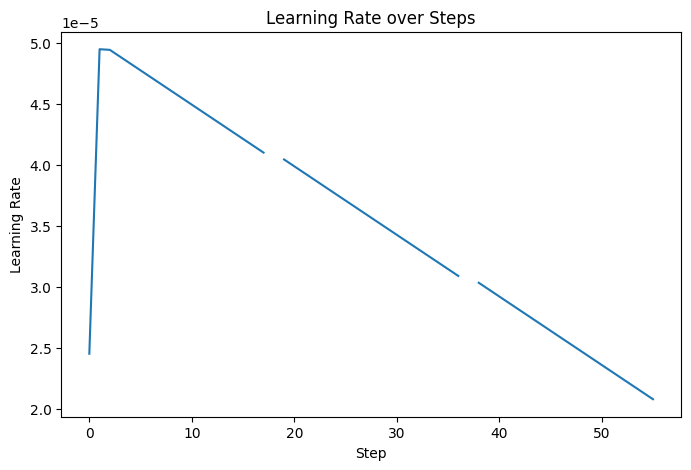

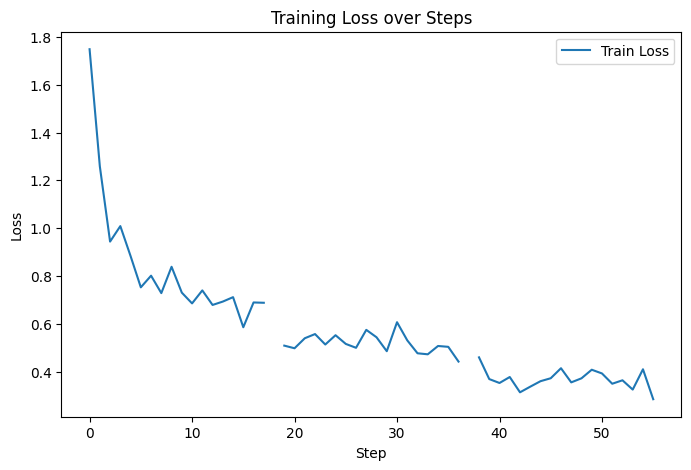

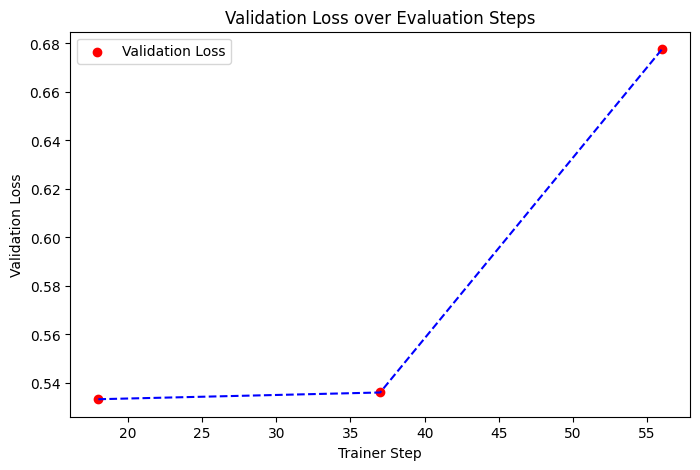

Validation Accuracy: 0.7801
Precision (macro): 0.7866
Recall (macro): 0.7797
F1-score (macro): 0.7815
Trainable params: 50164608 / 268100096


In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig
)

# ===============================
# 1. تنظیمات اولیه
# ===============================
model_name = "google/gemma-3-270m"

# بارگذاری توکنایزر
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

num_labels = 3  # e, c, n

# مدل را در حالت quantized بالا می‌آوریم
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    device_map="auto"  # به صورت خودکار بین GPU/CPU پخش می‌کند
)

print(model)




# Freeze کردن همه پارامترها
for param in model.parameters():
    param.requires_grad = False

# تعداد کل لایه‌ها
num_layers = len(model.model.layers)

# نصف انتهایی را آزاد می‌کنیم
for layer in model.model.layers[num_layers//2:]:
    for param in layer.parameters():
        param.requires_grad = True

# لایه classifier را هم آزاد می‌کنیم
for param in model.score.parameters():
    param.requires_grad = True



# ===============================
# 2. بارگذاری و آماده‌سازی دیتاست
# ===============================
df=train
df1=val

# نگاشت برچسب‌ها
label2id = {"e": 0, "c": 1, "n": 2}
id2label = {v: k for k, v in label2id.items()}
df["label_id"] = df["label"].map(label2id)
df1["label_id"] = df1["label"].map(label2id)

# ساخت prompt برای هر نمونه
def make_prompt(row):
    return (
        "جمله اول را پایه قرار بده و بگو آیا جمله دوم از آن نتیجه می‌شود (e)، "
        "با آن تضاد دارد (c)، یا هیچ رابطه‌ای ندارد (n):\n"
        f"جمله اول: {row['premise']}\n"
        f"جمله دوم: {row['hypothesis']}\n"
        "نتیجه:"
    )

df["prompt"] = df.apply(make_prompt, axis=1)
df1["prompt"] = df1.apply(make_prompt, axis=1)

dataset = Dataset.from_pandas(df[["prompt", "label_id"]])
dataset1 = Dataset.from_pandas(df1[["prompt", "label_id"]])


dataset = dataset.rename_column("label_id", "labels")

dataset1 = dataset1.rename_column("label_id", "labels")

# تقسیم train / validation
train_ds = dataset
val_ds = dataset1

# ===============================
# 3. توکن‌سازی
# ===============================
def tokenize_fn(examples):
    return tokenizer(
        examples["prompt"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

# ===============================
# 5. تنظیم Trainer
# ===============================
data_collator = DataCollatorWithPadding(tokenizer)


training_args = TrainingArguments(
    output_dir="./gemma3_te_finetuned",
    num_train_epochs=5,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_steps=50,
    fp16=False,
    bf16=True,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    warmup_steps=100  

)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}


from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

# ===============================
# 6. آموزش مدل
# ===============================
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

trainer.train()

# ===============================
# 7. ذخیره مدل نهایی
# ===============================
model.save_pretrained("./gemma3_textual_entailment_fa")
tokenizer.save_pretrained("./gemma3_textual_entailment_fa")




# 8. رسم نمودارها و محاسبه متریک‌ها
# ===============================
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# بارگذاری logs
logs = pd.DataFrame(trainer.state.log_history)

# --- نمودار تغییر نرخ یادگیری ---
if 'learning_rate' in logs.columns:
    plt.figure(figsize=(8,5))
    plt.plot(logs['learning_rate'])
    plt.title("Learning Rate over Steps")
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.show()

# --- نمودار train loss ---
if 'loss' in logs.columns:
    plt.figure(figsize=(8,5))
    plt.plot(logs['loss'], label="Train Loss")
    plt.title("Training Loss over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

eval_logs = logs[logs['eval_loss'].notnull()]

plt.figure(figsize=(8,5))
plt.scatter(eval_logs.index, eval_logs['eval_loss'], color='red', label="Validation Loss")
plt.plot(eval_logs.index, eval_logs['eval_loss'], color='blue', linestyle='--')  # اختیاری: خط راهنما
plt.title("Validation Loss over Evaluation Steps")
plt.xlabel("Trainer Step")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

# --- محاسبه precision / recall / f1 روی validation ---
val_preds = trainer.predict(val_ds)
preds = val_preds.predictions.argmax(axis=-1)
labels = val_preds.label_ids

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")




trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")

